This analysis uses the data on Lego sets from Rebrickable (https://rebrickable.com/downloads/). Amongst other information, the data set contains (across multiple tables) set and piece information for every Lego set produced from 1950 until 2017. The main purpose of this project is to get practice using Pandas, Numpy and Matplotlib and at data wrangling, cleaning, exploration and visualisation. Note that I did attempt to use a couple of ML algorithms for practice even though I recognise this is not the best use case for them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
colors = pd.read_csv('colors.csv')
inventories = pd.read_csv('inventories.csv')
inventory_parts = pd.read_csv('inventory_parts.csv')
inventory_sets = pd.read_csv('inventory_sets.csv')
part_categories = pd.read_csv('part_categories.csv')
parts = pd.read_csv('parts.csv')
sets = pd.read_csv('sets.csv')
themes = pd.read_csv('themes.csv')

In [3]:
sets.head()

,set_num,name,year,theme_id,num_parts
0,00-1,Weetabix Castle,1970,414,471
1,0011-2,Town Mini-Figures,1978,84,12
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2
3,0012-1,Space Mini-Figures,1979,143,12
4,0013-1,Space Mini-Figures,1979,143,12


In [5]:
sets.describe()

,year,theme_id,num_parts
count,11673.000000,11673.000000,11673.000000
mean,2001.972758,311.308575,162.262400
std,13.475364,177.999101,330.192108
min,1950.000000,1.000000,-1.000000
25%,1997.000000,161.000000,10.000000
50%,2005.000000,324.000000,45.000000
75%,2012.000000,470.000000,172.000000
max,2017.000000,614.000000,5922.000000


## How have the size of lego sets changed over time?

### Data exploration:

The number of pieces per set data is extremely right skewed, i.e. almost 1/4 of Lego sets have less than 10 pieces and over half have less than 50 pieces. However, there is a long right tail e.g. the 75th percentile is achieved at 172 pieces and the largest set is over 5900 pieces. The minimum set size is -1 which is clearly not right and will need to be fixed.

count    11673.000000
mean       162.262400
std        330.192108
min         -1.000000
25%         10.000000
50%         45.000000
75%        172.000000
max       5922.000000
Name: num_parts, dtype: float64 

< 10 pieces:  23.8  %
< 20 pieces:  32.53  %
< 50 pieces:  52.15  %
< 100 pieces:  66.08  %
< 200 pieces:  77.72  %
< 500 pieces:  91.34  %
< 1000 pieces:  97.53  %
< 2000 pieces:  99.39  %


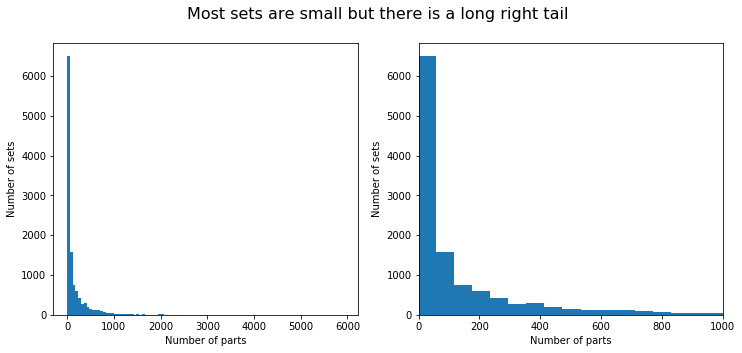

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,5));
fig.subplots_adjust(wspace=0.2);
fig.suptitle('Most sets are small but there is a long right tail', fontsize=16)

ax[0].hist(sets['num_parts'], bins=100);
ax[0].set(xlabel='Number of pieces', ylabel='Number of sets')

ax[1].hist(sets['num_parts'], bins=100);
ax[1].set_xlim(0, 1000);
ax[1].set(xlabel='Number of pieces', ylabel='Number of sets')

print(sets['num_parts'].describe(), "\n")

for lego_size in [10, 20, 50, 100, 200, 500, 1000, 2000]:
    pct_of_sets = 100 * len(sets[sets['num_parts'] < lego_size]) / len(sets['num_parts'])
    print("<", lego_size, "pieces: ", round(pct_of_sets, 2), " %")

### Data cleaning:

There are 473 'bad' sets (those with 0 or -1 pieces) and 39 of the 67 years have at least one bad set. The number of 'bad' sets per year has generally been increasing over time. These sets will be removed.

Num of bad sets: 473
Years with at least 1 bad set: 39


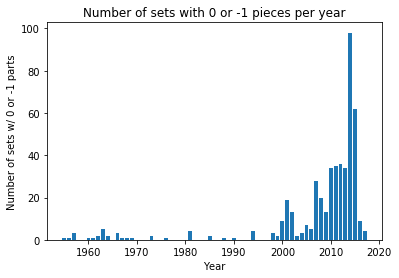

In [21]:
bad_sets = sets[(sets['num_parts'] == 0) | (sets['num_parts'] == 0)]
print("Num of bad sets:", len(bad_sets['num_parts']))
print("Years with at least 1 bad set:", sets[sets['num_parts'] <= 0]['year'].nunique())

sets_per_yr = bad_sets.groupby('year')['num_parts'].count()
plt.bar(sets_per_yr.index, sets_per_yr);
plt.xlabel('Year');
plt.ylabel('Number of sets w/ 0 or -1 parts');
plt.title('Number of sets with 0 or -1 pieces by year');

In [9]:
sets_clean = sets.loc[(sets['num_parts'] != 0) & (sets['num_parts'] != -1)]

### More data exploration:

Average:
- The average size of Lego sets has increased over time. However, the trend has not been linear.
- There was a general increase in average number of pieces per set from 1950 until the early 1970's (1960 is an outlier because there were only 2 sets in that year and one contained a large number of pieces).
- From the early 1970's until the mid 1980's, the average fluctuated up and down but there is no clear trend.
- From the mid 1980's until around 2005, the average set size increased rapidly before crashing over the next 5 years and then subsequently recovering to 2005 levels by around 2015.

Median:
- The median was increasing in general from 1950-1970 but there was no clear trend from 1970-2010. The median has been trending upward since 2010. This suggests that the 'big' sets have been getting bigger over but the typical set has stayed roughly the same size over time.

The number of sets released per year has increased over time and in a non-linear fashion.

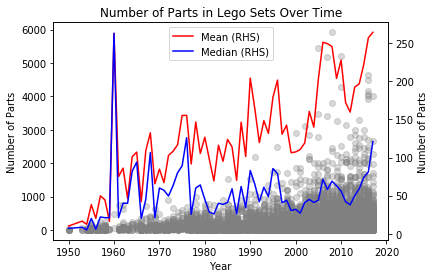

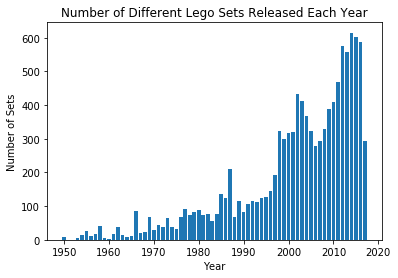

In [31]:
fig = plt.figure();
ax1 = plt.axes();

ax1.scatter(x='year', y='num_parts', data=sets_clean, color='gray', alpha=0.3);
ax1.set(xlabel='Year', ylabel='Number of Parts',
       title='Number of Pieces in Lego Sets Over Time');

ax2 = ax1.twinx();
ax2.plot(sets_clean.groupby('year')['num_parts'].mean(), 
         color='red', label='Mean (RHS)');
ax2.set_ylabel('Number of Pieces');
ax2.legend();

ax2.plot(sets_clean.groupby('year')['num_parts'].median(), 
         color='blue', label='Median (RHS)');
ax2.set_ylabel('Number of Pieces');
ax2.legend();

numsets = sets_clean.groupby('year')['num_parts'].count()

fig = plt.figure();
ax = plt.axes();
ax.bar(numsets.index, numsets);
ax.set(xlabel='Year', ylabel='Number of Sets',
       title='Number of Different Lego Sets Released Each Year');

The following grouped box-plot confirms that the distribution of the number of pieces in Lego sets by decade is right skew and the skew has been increasing. I.e. most sets have a 'small' number of pieces but the largest sets have been getting bigger.

In [26]:
bins = [1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
names = ['50-60', '60-70', '70-80', '80-90', '90-00', '00-10',
         '10-20']
sets_clean['year_range'] = pd.cut(sets_clean['year'], bins, right=False, labels=names)
sets_clean['year_range'].unique()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[70-80, 80-90, 60-70, 90-00, 00-10, 10-20, 50-60]
Categories (7, object): [50-60 < 60-70 < 70-80 < 80-90 < 90-00 < 00-10 < 10-20]

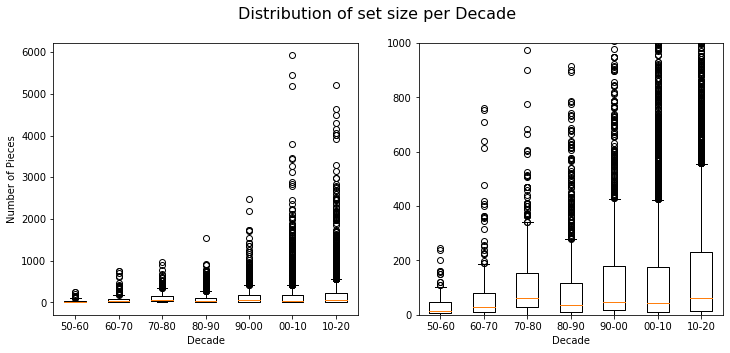

In [41]:
data = []
for name in names:
    data.append(sets_clean[sets_clean['year_range']==name]['num_parts'])

fig, ax = plt.subplots(1, 2, figsize=(12,5));
fig.subplots_adjust(wspace=0.2);
plt.suptitle('Distribution of set size per Decade', fontsize=16)

ax[0].boxplot(x=data, labels=names);
ax[0].set(xlabel='Decade', ylabel='Number of Pieces');

ax[1].boxplot(x=data, labels=names);
ax[1].set(xlabel='Decade', ylim=(0,1000));

The left hand chart below confirms that larger sets (third quartile and above) have been getting much larger over time, whereas smaller sets (median size and below) have increased in size minimally if at all. The increase in the size of the largest sets has driven an increase in the mean set size.

The right hand plot shows that amongst the largest sets (third quartile and above), the rate of increase has been higher for larger sets (i.e. the sets in the 99th percentile has been increasing even faster than those in the 90th percentile etc.). In other words, the left hand chart showed that large sets have been getting larger but the right hand chart shows that very large sets have been larger at an even faster rate than large sets.

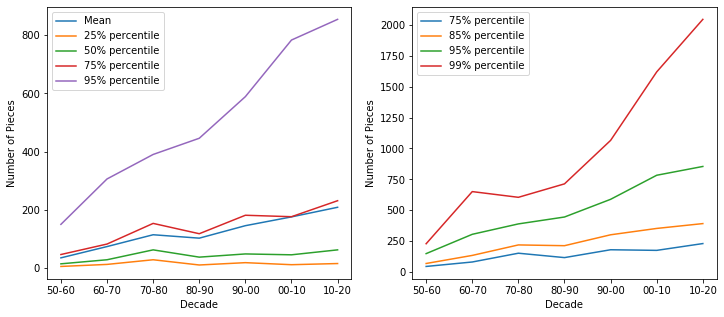

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12,5));
fig.subplots_adjust(wspace=0.2);

avg_parts = sets_clean.groupby('year_range')['num_parts'].mean()
ax[0].plot(np.array(avg_parts.index), avg_parts, label='Mean');

def plot_percentiles(plot_num, percentiles):
#percentiles = []
    for percentile in percentiles:
        percentile_tmp = sets_clean.groupby('year_range')['num_parts'].quantile(percentile)
        ax[plot_num].plot(np.array(percentile_tmp.index), percentile_tmp, 
                 label=str(int(100*percentile)) + "% percentile");

    ax[plot_num].set(xlabel='Decade', ylabel='Number of Pieces');
    ax[plot_num].legend();


plot_percentiles(0, [0.25, 0.5, 0.75, 0.95])
plot_percentiles(1, [0.75, 0.85, 0.95, 0.99])

## In what other ways have Lego sets changed over time?

The data to answer this question is spread across multiple tables. This data needs to be joined, cleaned and explored before answering the question.

In [49]:
# what is the inventories table?

inventories.head()

,id,version,set_num
0,1,1,7922-1
1,3,1,3931-1
2,4,1,6942-1
3,15,1,5158-1
4,16,1,903-1


In [50]:
# 11 sets appear more than once in the data. Why?

len(inventories['set_num']) - len(inventories['set_num'].unique())

11

In [78]:
# Some sets appear to have multiple versions but seem otherwise identical. Wait until more data is joined before
# deciding what to do with these extra versions.

inv_sets = pd.merge(inventories, sets, how='left', on='set_num')
versions_per_set = inv_sets.groupby('set_num')['version'].count()
idx = versions_per_set[versions_per_set > 1].index # find sets which have more than 1 version
inv_sets.loc[inv_sets['set_num'].isin(idx)].drop(columns='name').sort_values(by=['set_num', 'version'])

,id,version,set_num,year,theme_id,num_parts
565,817,1,11905-1,2013,497,189
11479,16760,2,11905-1,2013,497,189
367,531,1,214.6-1,1961,371,15
11581,17799,2,214.6-1,1961,371,15
2250,3217,1,31015-1,2014,22,56
11626,18231,2,31015-1,2014,22,56
9848,14143,1,421-2,1966,371,20
11585,17848,2,421-2,1966,371,20
11586,17849,3,421-2,1966,371,20
11587,17850,4,421-2,1966,371,20


Join all the tables together:

In [309]:
themes.rename(columns = {"name" : "theme_name"}, inplace = True)
colors.rename(columns = {"name" : "color"}, inplace = True)
parts.rename(columns = {"name" : "part_name"}, inplace = True)
part_categories.rename(columns = {"name" : "partcat_name"}, inplace = True)

add_themes = pd.merge(sets_clean, themes, how='left', left_on='theme_id', right_on='id')
add_inv = pd.merge(add_themes, inventories, how='left', on='set_num')
add_invparts = pd.merge(add_inv, inventory_parts, how='left', left_on='id_y', right_on='inventory_id')
add_colours = pd.merge(add_invparts, colors, how='left', left_on='color_id', right_on='id')
add_parts = pd.merge(add_colours, parts, how='left', on='part_num')
add_partcats = pd.merge(add_parts, part_categories, how='left', left_on='part_cat_id', right_on='id')

add_partcats.head()

KeyError: 'id'

In [310]:
# how has adding other tables increased the size of the data?
print(add_themes.shape, add_inv.shape, add_parts.shape, add_colours.shape, add_parts.shape, add_partcats.shape)

# remove irelevant columns
cols_to_remove = ['theme_id', 'id_x', 'parent_id', 'inventory_id',
                 'color_id', 'id_y', 'part_num', 'part_cat_id']
data_all = add_partcats.drop(columns = cols_to_remove)

data_all.head()

(11197, 9) (11208, 11) (580735, 22) (580735, 20) (580735, 22) (580735, 24)


,set_num,name,year,num_parts,year_range,theme_name,version,quantity,is_spare,color,rgb,is_trans,part_name,partcat_name
0,00-1,Weetabix Castle,1970,471,70-80,Castle,1.0,8.0,f,Red,C91A09,f,Window 1 x 1 x 2 with Glass,Windows and Doors
1,00-1,Weetabix Castle,1970,471,70-80,Castle,1.0,6.0,f,White,FFFFFF,f,Window 1 x 1 x 2 with Glass,Windows and Doors
2,00-1,Weetabix Castle,1970,471,70-80,Castle,1.0,25.0,f,White,FFFFFF,f,Brick 2 x 4 without Cross Supports,Bricks
3,00-1,Weetabix Castle,1970,471,70-80,Castle,1.0,9.0,f,Red,C91A09,f,Brick 2 x 4 without Cross Supports,Bricks
4,00-1,Weetabix Castle,1970,471,70-80,Castle,1.0,4.0,f,Blue,0055BF,f,Brick 2 x 4 without Cross Supports,Bricks


### Data cleaning:

In [311]:
# I can't see any difference between different versions of the same set.
# Therefore, delete versions > 1.

data_all[data_all['set_num'] == '421-2'].drop(columns='name').head(50) # example of a set with multiple versions

,set_num,year,num_parts,year_range,theme_name,version,quantity,is_spare,color,rgb,is_trans,part_name,partcat_name
177824,421-2,1966,20,60-70,Supplemental,1.0,8.0,f,Yellow,F2CD37,f,Brick 1 x 2,Bricks
177825,421-2,1966,20,60-70,Supplemental,1.0,6.0,f,Yellow,F2CD37,f,Brick 1 x 1,Bricks
177826,421-2,1966,20,60-70,Supplemental,1.0,2.0,f,Yellow,F2CD37,f,Brick 1 x 8,Bricks
177827,421-2,1966,20,60-70,Supplemental,1.0,2.0,f,Yellow,F2CD37,f,Brick 1 x 6,Bricks
177828,421-2,1966,20,60-70,Supplemental,1.0,2.0,f,Yellow,F2CD37,f,Brick 1 x 4,Bricks
177829,421-2,1966,20,60-70,Supplemental,2.0,8.0,f,Red,C91A09,f,Brick 1 x 2,Bricks
177830,421-2,1966,20,60-70,Supplemental,2.0,6.0,f,Red,C91A09,f,Brick 1 x 1,Bricks
177831,421-2,1966,20,60-70,Supplemental,2.0,2.0,f,Red,C91A09,f,Brick 1 x 8,Bricks
177832,421-2,1966,20,60-70,Supplemental,2.0,2.0,f,Red,C91A09,f,Brick 1 x 6,Bricks
177833,421-2,1966,20,60-70,Supplemental,2.0,2.0,f,Red,C91A09,f,Brick 1 x 4,Bricks


In [312]:
#data_all[data_all['version'] > 1].index
data_all.drop(data_all[data_all['version'] > 1].index, inplace = True)
data_all.drop(columns = 'version', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [313]:
# add a # to the RGB values so they can be used in charts

data_all.loc[:,'rgb'] = '#' + data_all.loc[:, 'rgb']

In [314]:
# how many missing values are there?

for column in data_all.columns:
    print(column, len(data_all.loc[data_all[column].isna()]))

set_num 0
name 0
year 0
num_parts 0
year_range 0
theme_name 0
quantity 484
is_spare 484
color 484
rgb 484
is_trans 484
part_name 666
partcat_name 666


In [315]:
# drop missing values
data_all.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [316]:
# look through the classes for each categorical variables to find errors
print(data_all['is_spare'].unique(), '\n')
print(data_all['is_trans'].unique(), '\n')
print(data_all['color'].unique(), '\n')
print(data_all['theme_name'].unique(), '\n')
print(data_all['partcat_name'].unique(), '\n')

['f' 't'] 

['f' 't'] 

['Red' 'White' 'Blue' 'Yellow' 'Light Gray' 'Black' 'Trans-Clear' 'Green'
 'Trans-Red' 'Trans-Green' 'Milky White' 'Dark Gray' 'Brown'
 'Trans-Yellow' 'Trans-Light Blue' 'Sand Red' 'Tan' 'Chrome Silver'
 'Trans-Neon Orange' '[No Color]' 'Dark Red' 'Royal Blue'
 'Pearl Light Gray' 'Orange' 'Flat Silver' 'Trans-Black' 'Trans-Dark Blue'
 'Chrome Gold' 'Bright Pink' 'Trans-Dark Pink' 'Trans-Pink' 'Dark Pink'
 'Pink' 'Chrome Pink' 'Light Orange' 'Trans-Orange' 'Light Salmon' 'Aqua'
 'Trans-Purple' 'Trans-Very Lt Blue' 'Sand Blue' 'Trans-Bright Green'
 'Bright Light Blue' 'Trans-Neon Green' 'Dark Bluish Gray' 'Medium Blue'
 'Dark Blue' 'Light Bluish Gray' 'Reddish Brown' 'Sand Green'
 'Dark Orange' 'Dark Green' 'Copper' 'Pearl Dark Gray' 'Pearl Light Gold'
 'Light Flesh' 'Maersk Blue' 'Bright Green' 'Magenta' 'Pearl Gold'
 'Speckle Black-Silver' 'Glow In Dark Trans' 'Metallic Gold'
 'Metallic Silver' 'Lime' 'Dark Tan' 'Trans-Medium Blue' 'Dark Brown'
 'Bright Light Or

In [317]:
# drop pieces which have '[No Color]' or 'unknown' color

indices = data_all[(data_all['color'] == '[No Color]') | (data_all['color'] == 'Unknown')].index
data_all.drop(index=indices, inplace=True)

In [318]:
# The sets data was already cleaned for sets with 0 or -1 parts so there are no bad values for 'quantity'

data_all[data_all['quantity'] < 1]

,set_num,name,year,num_parts,year_range,theme_name,quantity,is_spare,color,rgb,is_trans,part_name,partcat_name


### Data exploration:

The following table shows the number of unique classes in each categorical variable of interest:

In [113]:
# check how many unique categories left

print("Uniquie colours:", str(data_all['color'].nunique()))
print("Uniquie themes:", str(data_all['theme_name'].nunique()))
print("Uniquie parts:", str(data_all['part_name'].nunique()))
print("Uniquie parts categories:", str(data_all['partcat_name'].nunique()))
print("Total number of parts:", str(data_all['quantity'].sum()))

Uniquie colours: 129
Uniquie themes: 379
Uniquie parts: 20930
Uniquie parts categories: 57
Total number of parts: 1923008.0


The number of unique part categories, themes and colours has increased substantially over time. However, the number of unqiue colours has declined substantially since the early 2000's.

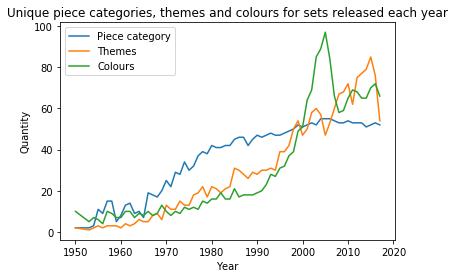

In [133]:
partcat_by_year = data_all.groupby('year')['partcat_name'].nunique()
themes_by_year = data_all.groupby('year')['theme_name'].nunique()
colours_by_year = data_all.groupby('year')['color'].nunique()
sets_by_year = data_all.groupby('year')['set_num'].nunique()

X = partcat_by_year.index
plt.plot(X, partcat_by_year, label="Piece category")
plt.plot(X, themes_by_year, label="Themes")
plt.plot(X, colours_by_year, label="Colours")

plt.xlabel('Year');
plt.ylabel('Quantity');
plt.title('Unique piece categories, themes and colours for sets released each year');
plt.legend();

50% of all pieces fall into just 5 categories and 3 colours:

In [134]:
def field_distribution(field, print_name):
    quantities = data_all.groupby(field)['quantity'].sum()/data_all['quantity'].sum()
    quantities.sort_values(inplace=True, ascending=False)
    return [len(quantities[quantities.cumsum() < pct]) for pct in [0.5, 0.75, 0.90, 1.01]] 
        
dist_frame = pd.DataFrame({
    '% of Pieces' : ['50%', '75%', '90%', '100%'],
    'Piece Categories' : field_distribution('partcat_name', 'part categories'),
    'Colors' : field_distribution('color', 'colours'),
    'Themes' : field_distribution('theme_name', 'themes'),
    'Pieces' : field_distribution('part_name', 'parts')
})

dist_frame

,% of Pieces,Piece Categories,Colors,Themes,Pieces
0,50%,5,3,29,53
1,75%,13,7,81,256
2,90%,22,18,159,900
3,100%,57,129,379,20930


Similar to the total number of parts in Lego sets over time, the number of unique pieces and number of unique colours in Lego sets has been increasing over time. However, the data is nowhere near as right skew as the median increases over time along with the mean.

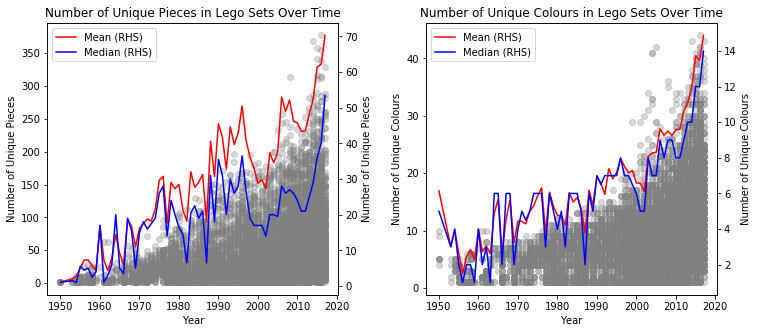

In [132]:
per_set_stats = data_all.groupby(['set_num', 'year'])[['part_name', 'color']].nunique().reset_index()
per_set_stats.rename(columns={'part_name' : 'unique_parts',
                              'color' : 'unique_colors'}, inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(12,5));
fig.subplots_adjust(wspace=0.3);

def chart_stats(plot_num, field, print_name, dataset):
    ax[plot_num].scatter(x='year', y=field, data=dataset, color='gray', alpha=0.3);
    ax[plot_num].set(xlabel='Year', ylabel=print_name);

    ax2 = ax[plot_num].twinx();
    ax2.plot(dataset.groupby('year')[field].mean(), color='red', label='Mean (RHS)');
    ax2.set_ylabel(print_name);
    ax2.legend();

    ax2.plot(dataset.groupby('year')[field].median(), color='blue', label='Median (RHS)');
    ax2.set_ylabel(print_name);
    ax2.legend();
    
    ax[plot_num].set_title(print_name + ' in Lego Sets Over Time');

chart_stats(0, 'unique_parts', 'Number of Unique Pieces', per_set_stats)
chart_stats(1, 'unique_colors', 'Number of Unique Colours', per_set_stats)

The following correlations and scatter plots show that sets with more total parts also have more unique parts (not unexpected!), but sets with more total parts usually have more unique colours but not always (correlation not as strong as between number of parts and number of unique parts).

,unique_parts,unique_colors,num_parts
unique_parts,1.000000,0.799353,0.708013
unique_colors,0.799353,1.000000,0.514251
num_parts,0.708013,0.514251,1.000000


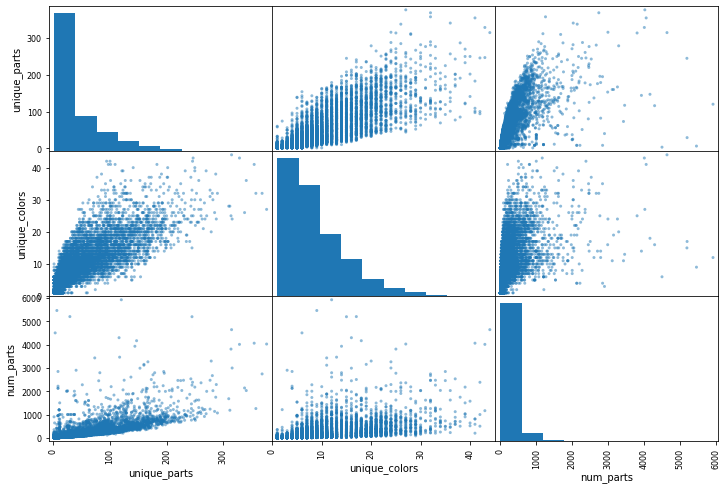

In [895]:
from pandas.plotting import scatter_matrix

per_set_stats_all = pd.merge(per_set_stats, sets_clean, how='left', on='set_num')

scatter_matrix(per_set_stats_all[['unique_parts', 'unique_colors', 'num_parts']], figsize=(12,8));
per_set_stats_all[['unique_parts', 'unique_colors', 'num_parts']].corr()

### Investigate colours in more depth:

Rarest and most common colours (the 5th rarest isn't displaying properly):

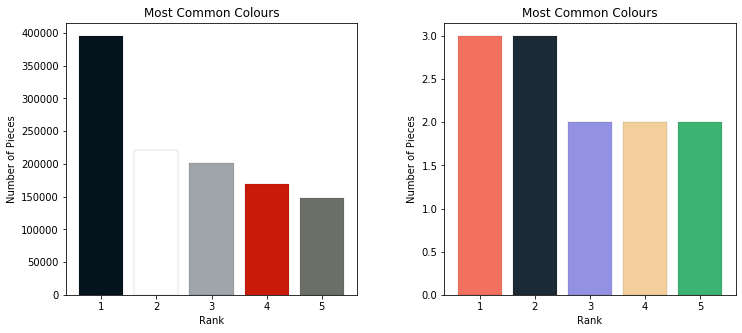

In [136]:
colours_data = data_all.groupby(['color', 'rgb'])['quantity'].sum().sort_values(ascending=False).reset_index()
top5 = colours_data[0:5]
bottom5 = colours_data[len(colours_data)-6:len(colours_data)-1]

fig, ax = plt.subplots(1, 2, figsize=(12,5));
fig.subplots_adjust(wspace=0.3);

ax[0].bar(range(1,6), top5['quantity'], color=top5['rgb'], edgecolor='black', linewidth=0.1);
ax[0].set(xlabel='Rank', ylabel='Number of Pieces', title='Most Common Colours');

ax[1].bar(range(1,6), bottom5['quantity'], color=bottom5['rgb'], edgecolor='black', linewidth=0.1);
ax[1].set(xlabel='Rank', ylabel='Number of Pieces', title='Rarest Colours');

The following chart shows that the top 10 colours make up a smaller percentage of the total pieces now than in previous decades (in line with there being far more colours). Also, the percentage of black and grey pieces has increased substantially, and the percentage of white pieces has declined.

In [138]:
clr_decade = data_all.pivot_table(index=['year_range', 'color', 'rgb'], values='quantity', aggfunc='sum').reset_index()
clr_decade['rank'] = clr_decade.groupby('year_range')['quantity'].rank(ascending=False, method='first')

clr_decade['decade_tot_quant'] = clr_decade.groupby('year_range')['quantity'].transform('sum')
clr_decade['pct_of_tot'] = 100 * clr_decade['quantity'] / clr_decade['decade_tot_quant']
clr_decade.drop(clr_decade[clr_decade['rank'] > 10].index, inplace=True)

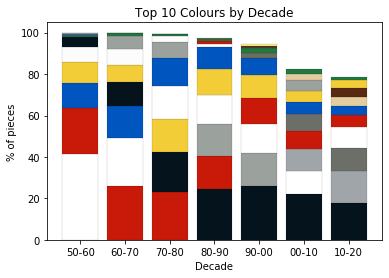

In [140]:
btm = np.zeros(7,)
for rank in range(1, 11):
    curr_rank_data = clr_decade[clr_decade['rank']==rank][['year_range', 'pct_of_tot', 'rgb']] 
    plt.bar(curr_rank_data['year_range'], curr_rank_data['pct_of_tot'],
            color=curr_rank_data['rgb'], bottom=btm, edgecolor='black', linewidth=0.1)
    btm = btm + np.array(curr_rank_data['pct_of_tot'])

plt.xlabel('Decade');
plt.ylabel('% of pieces');
plt.title('Top 10 Colours by Decade');

### Can a set's theme be predicted from it's pieces?

This is not a great dataset for this task and I'm not sure why predicting the theme of a set based on it's pieces would be useful. Hence, this is more for practice than anything!

In [412]:
# there are 379 themes! export a list of themes to Excel to try and consolidate them

top_themes = (data_all[['theme_name', 'set_num']].drop_duplicates()
              .groupby('theme_name')
              .count()
              .reset_index()
              .sort_values(by='set_num', ascending=False))

top_themes.to_excel('themes_data.xlsx')

In [327]:
# there are too many theme names and many can be classed together

data_all['theme_name_refined'] = data_all['theme_name']

# data_all.replace(to_replace={'theme_name_refined' : r'Classic.*'}, value='Classic', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Classic.*', value='Classic', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Planet Series.*', value='Planet Series', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Matoran.*', value='Matoran', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Blacktron.*', value='Blacktron', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Aquaraiders.*', value='Aquaraiders', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Bohrok.*', value='Bokrok', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Space Police.*', value='Space Police', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Star Wars.*', value='Star Wars', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Minifig.*', value='Minifigures', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Series.*', value='Minifigures', regex=True, inplace=True)
data_all['theme_name_refined'].replace(to_replace=r'Basic.*', value='Basic', regex=True, inplace=True)

data_all['theme_name_refined'].to_excel('new_themes.xlsx')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Try and predict the top 5 themes from the pieces they contain:


In [400]:
numcats = 5

top_themes = (data_all[['theme_name_refined', 'set_num']].drop_duplicates()
              .groupby('theme_name_refined')
              .count()
              .reset_index()
              .nlargest(numcats,'set_num'))

top_themes.rename(columns={'set_num' : 'count'}, inplace=True)
top_themes

,theme_name_refined,count
254,Star Wars,577
261,Supplemental,488
27,Basic,443
263,Technic,416
170,Minifigures,359


In [404]:
# transform the data to an appropriate format

import random

cols = ['set_num', 'partcat_name', 'quantity', 'theme_name_refined', 'rgb']
data_final = data_all[cols].pivot_table(index=['set_num', 'theme_name_refined'], columns='partcat_name', 
                                        values='quantity', aggfunc=sum, fill_value=0).reset_index()

colors = [(random.random(), random.random(), random.random()) for i in range(numcats)]
theme_colors = pd.DataFrame({'theme_name_refined' : top_themes['theme_name_refined'], 'color' : colors})

data_final = data_final[data_final['theme_name_refined'].isin(top_themes['theme_name_refined'])]
data_final = data_final.merge(theme_colors, how='left', on='theme_name_refined')
color_col = data_final.pop('color')
data_final.insert(2, 'color', color_col)
data_final.head()

,set_num,theme_name_refined,color,"Bars, Ladders and Fences",Baseplates,"Belville, Scala and Fabuland","Bionicle, Hero Factory and Constraction",Bricks,Bricks Curved,Bricks Printed,...,Tiles Printed,Tiles Special,Tools,Transportation - Land,Transportation - Sea and Air,Tubes and Hoses,Wheels and Tyres,Windows and Doors,Windscreens and Fuselage,Znap
0,0011-2,Supplemental,"(0.5829894491483006, 0.6666379097528868, 0.200...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0012-1,Supplemental,"(0.5829894491483006, 0.6666379097528868, 0.200...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0013-1,Supplemental,"(0.5829894491483006, 0.6666379097528868, 0.200...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0014-1,Supplemental,"(0.5829894491483006, 0.6666379097528868, 0.200...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0015-1,Supplemental,"(0.5829894491483006, 0.6666379097528868, 0.200...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The following PCA shows that other than the Star Wars theme, the classes are not really separable in 2 dimesions:

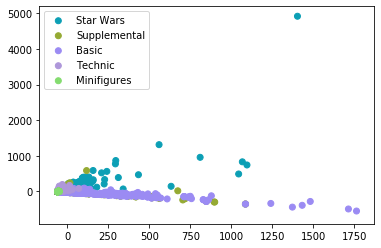

In [405]:
from sklearn.decomposition import PCA

X = data_final.drop(columns=['set_num', 'theme_name_refined', 'color'])

pca = PCA(n_components=10)
X2D = pca.fit_transform(X)

for theme in top_themes['theme_name_refined']:
    indices = (data_final['theme_name_refined']==theme)
    plt.scatter(X2D[indices, 0], X2D[indices, 1], color=data_final.loc[indices, 'color'],
               label=theme);

plt.legend();

In [406]:
from sklearn.model_selection import train_test_split

X = data_final.drop(columns=['set_num', 'theme_name_refined', 'color'])
y = data_final['theme_name_refined']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [407]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=300)
lr_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

This classifier performs surprisingly well:

In [408]:
y_train_pred = lr_clf.predict(X_train)
y_test_pred = lr_clf.predict(X_test)

In [409]:
sum(y_train_pred == y_train) / len(y_train), sum(y_test_pred == y_test) / len(y_test)

(0.7908878504672897, 0.7758318739054291)

array([['Star Wars', 0.6756756756756757],
       ['Supplemental', 0.9887640449438202],
       ['Basic', 0.782051282051282],
       ['Technic', 0.5371900826446281],
       ['Minifigures', 0.9893617021276596]], dtype=object)

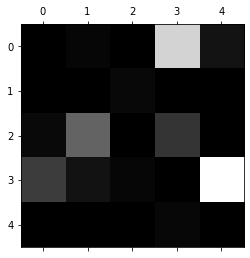

In [411]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

conf_mtrx = confusion_matrix(y_test, y_test_pred)
row_sums = conf_mtrx.sum(axis=1, keepdims=True)
norm_conf_mtrx = conf_mtrx / row_sums
np.fill_diagonal(norm_conf_mtrx, 0)
plt.matshow(norm_conf_mtrx, cmap=plt.cm.gray);

np.c_[top_themes['theme_name_refined'], conf_mtrx.diagonal() / conf_mtrx.sum(axis=1)]

### Model the increase in set size over time

Attempt the model the increase in number of parts per set over time with linear regression. This data set is totally innapropriate for linear regression so the following is more for practice than anything!

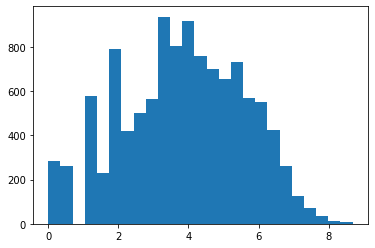

In [141]:
# Apply a log transform to the highly right skewed set size data.

log_num_parts = np.log(sets_clean['num_parts'])
plt.hist(log_num_parts, bins=25);

In [319]:
# diagnostics for statistical inference - to be used later

def qqplot_zscores(n):
    import scipy.stats as st
    return [st.norm.ppf((k - 0.375) / (n - 0.25)) for k in range(1, n+1)]

def diagnostic_plots(y, y_pred):
    resids = y - y_pred

    # information needed for qqplot
    z_scores = qqplot_zscores(len(resids))
    sorted_resids = np.sort(np.ravel(resids))
    unit_normal_resids = (sorted_resids - sorted_resids.mean()) / sorted_resids.std()

    x_qq = np.linspace(-3, 3, 100)
    y_qq = x_qq

    # plots
    fig, ax = plt.subplots(2, 2, figsize=(12,12));
    fig.subplots_adjust(hspace=0.2, wspace=0.2);

    ax[0, 0].hist(resids);
    ax[0, 0].set(xlabel='Residuals', ylabel='Frequency')

    ax[0, 1].boxplot(resids);
    ax[0, 1].set_ylabel('Residuals')
    
    ax[1, 0].scatter(x=y_pred, y=resids);
    ax[1, 0].axhline(y=0, color='red');
    ax[1, 0].set(xlabel='Fitted Values', ylabel='Residuals')
    
    ax[1, 1].scatter(z_scores, unit_normal_resids);
    ax[1, 1].plot(x_qq, y_qq);
    ax[1, 1].set(xlabel='Theoretical Quantiles', ylabel='Residuals')

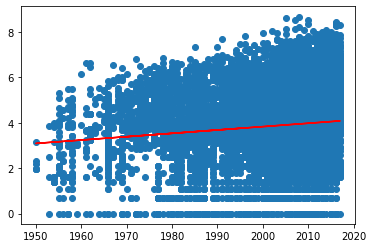

In [143]:
X = np.c_[sets_clean['year']]
y_log = np.c_[log_num_parts]

from sklearn.linear_model import LinearRegression
reg_model = LinearRegression()
reg_model.fit(X, y_log)
y_log_pred = reg_model.predict(X)

plt.scatter(X, y_log);
plt.plot(X, y_log_pred, color='red');

Surprisingly, the diagnostic plots suggest the model is ok.

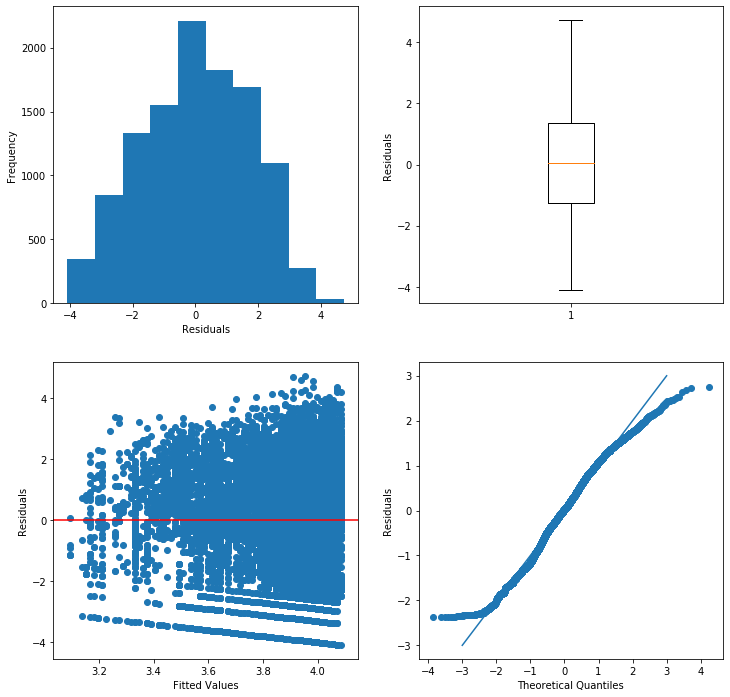

In [144]:
diagnostic_plots(y_log, y_log_pred)

The model fit is terrible per the following chart. This is likely because the true relationship is not linear, nor is it constant over time. Also, linear regression models the mean value and per the above plots, it's really only the third quartile and above where set size has been increasing which suggests a quantile regression is more appropriate.

Avg increase in set size over a year: 1.49 %


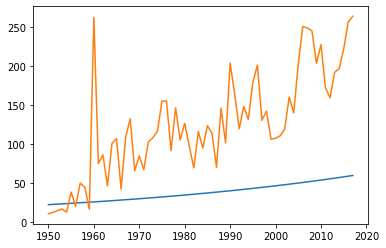

In [145]:
b0 = reg_model.intercept_
b1 = reg_model.coef_

print("Avg increase in set size over a year:", round(100 * (np.exp(b1)[0][0] - 1), 2), "%")

X_unique = np.sort(sets["year"].unique())
y_log_unique_pred = np.exp(b0 + b1 * X_unique)
y_log_unique_pred = y_log_unique_pred.reshape(-1,1)

plt.plot(X_unique, y_log_unique_pred);
plt.plot(sets_clean.groupby('year')['num_parts'].mean());